In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np

In [2]:
import glob
import matplotlib.image as mpimg

# import the raw images into arrays
x_train = []
x_test = []
for image in glob.glob('keras_png_slices_data/keras_png_slices_train/*.png'):
    x_train.append(mpimg.imread(image))
for image in glob.glob('keras_png_slices_data/keras_png_slices_test/*.png'):
    x_test.append(mpimg.imread(image))

In [4]:
# normalise each image and reshape them into 1D vectors
x_train = np.array(x_train).astype('float32') / 255.
x_test = np.array(x_test).astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape, x_test.shape)

(9664, 65536) (544, 65536)


In [5]:
depth = 32 # how much encoding to apply
length = 65536 # pixel size of each image
batch_size = 256

In [6]:
# create the network: first we encode in the inputs
inputs = Input(shape=(length,))
encoded = Dense(depth * 4, activation='relu')(inputs)
encoded = Dense(depth * 2, activation='relu')(encoded)
encoded = Dense(depth, activation='relu')(encoded)

# we've reached the latent space so now we decode
decoded = Dense(depth * 2, activation='relu')(encoded)
decoded = Dense(depth * 4, activation='relu')(decoded)
decoded = Dense(length, activation='sigmoid')(decoded)

# map an input to its reconstruction to create model
autoencoder = Model(inputs, decoded)

In [7]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
# fit the model to the data
autoencoder.fit(x_train, x_train, epochs=100, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/100
38/38 [==============================] - 30s 763ms/step - loss: 0.5142 - val_loss: 0.0049
Epoch 2/100
38/38 [==============================] - 25s 660ms/step - loss: 0.0097 - val_loss: 0.0108
Epoch 3/100
38/38 [==============================] - 25s 649ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 4/100
38/38 [==============================] - 25s 645ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 5/100
38/38 [==============================] - 25s 656ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 6/100
38/38 [==============================] - 25s 646ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 7/100
38/38 [==============================] - 25s 649ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 8/100
38/38 [==============================] - 25s 652ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 9/100
38/38 [==============================] - 25s 654ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 10/100
38/38 [==============================] - 25s 660ms/step - loss: 0.004

In [9]:
# let us test the model on some new images
decoded_imgs = autoencoder.predict(x_test)

17/17 [==============================] - 1s 20ms/step


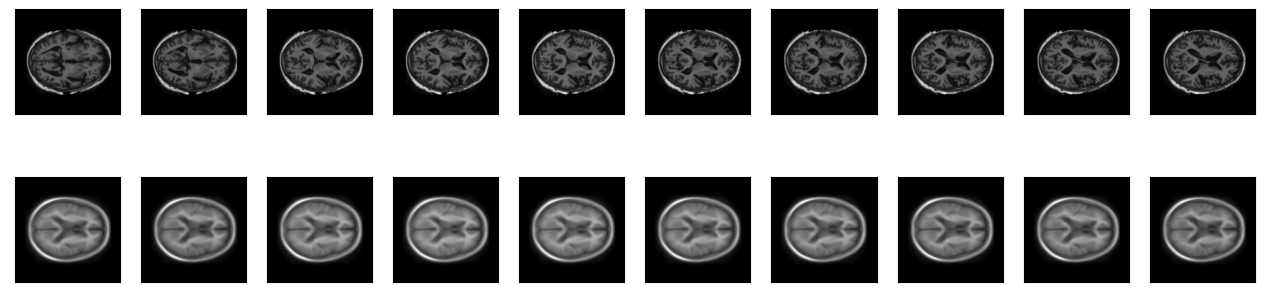

In [10]:
import matplotlib.pyplot as plt

n = 10  # how many scans we will display
plt.figure(figsize=(16, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

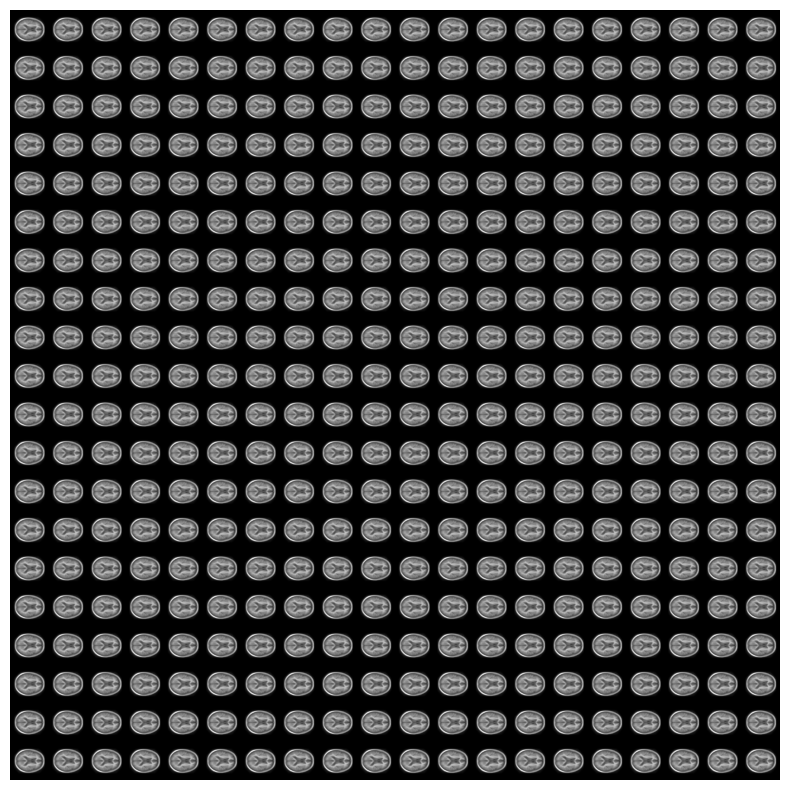

In [11]:
import tensorflow_probability as tfp

# create a 2D image of the resulting manifold
def plot_latent_images(model, n, image_size=256):
    """
    Plots n x n digit images decoded from the latent space.
    """
    norm = tfp.distributions.Normal(0, 1) # standard normal distribution
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = image_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            scan = tf.reshape(decoded_imgs[0], (image_size, image_size))
            image[i * image_size: (i + 1) * image_size,
                  j * image_size: (j + 1) * image_size] = scan.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

plot_latent_images(autoencoder, 20)